In [2]:
import sys
sys.path.insert(0, '..')

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from skimage.measure import label,regionprops
from skimage.transform import rescale
import dognet
from skimage.draw import circle

import torch
from torch.autograd import Variable
from sklearn.metrics import roc_curve, auc

### Load Dataset

In [3]:
def load_annotation(path,scale):
    anno = np.load(path)['collman15v2_annotation']
    layer = []
    for i in range(anno.shape[0]):
        props = regionprops(anno[i])
        yy = [p.centroid[0] * scale for p in props]
        xx = [p.centroid[1] * scale for p in props]
        layer.append([xx, yy])
    return layer

collman = np.load('../datasets/collman15/collman_large.npy')
layer = load_annotation("../datasets/collman15/collman15v2_annotation.npz",0.05)

In [4]:
#make training data (0-7 layers are reserved for testing with probabilitic model)

def inference(net,image,get_inter = False):
    x = np.expand_dims(image,0)
    vx = Variable(torch.from_numpy(x).float()).cuda()
    res,inter = net(vx)
    if get_inter:
        return res.data.cpu().numpy(),inter.data.cpu().numpy()
    return res.data.cpu().numpy()

# def estimate_quality(collman,net,slices=[2,3,4,5,6]):
#     mprecision=[]
#     mrecall=[]
#     mf1_score=[]
#     for s in slices:
#         y  = inference(net,np.stack([collman[:,s-1],collman[:,s], collman[:,s+1]],1))
#         gt_pts = np.array([layer[s][0],layer[s][1]]).transpose(1,0)
#         coords = np.array([ list(p.centroid) for p in regionprops(label(y[0,0]>0.7)) if p.area>0])
#         dog_pts = np.array([coords[:,1],coords[:,0]]).transpose(1,0)
#         precision,recall,f1_score,_ = dognet.get_metric(gt_pts,dog_pts,s=10.)
        
#         mprecision.append(precision)
#         mrecall.append(recall)
#         mf1_score.append(f1_score)
#     return np.mean(mf1_score),np.mean(mprecision),np.mean(mrecall)

def estimate_quality(collman,net,layer,slices=[2,3,4,5,6],th=0.7):
    mprecision=[]
    mrecall=[]
    mf1_score=[]
    auc_score=[]
    dic=[]
    for s in slices:
        y  = inference(net,np.stack([collman[:,s-1],collman[:,s], collman[:,s+1]],1))
        y_gt = make_labels(collman[:,0],np.array(layer[s])[:,0],np.array(layer[s])[:,1])
        fpr, tpr, thresholds = roc_curve( y_gt.flatten(),y[0,0].flatten())
        auc_score.append(auc(fpr, tpr))
            
        #gt_pts = np.array([np.array(layer[s])[:,1],np.array(layer[s])[:,0]]).transpose(1,0)
        gt_pts = np.array([layer[s][0],layer[s][1]]).transpose(1,0)
        #print(gt_pts)
        coords = np.array([ list(p.centroid) for p in regionprops(label(y[0,0]>th)) if p.area>0])
        #print(coords)
        dog_pts = np.array([coords[:,1],coords[:,0]]).transpose(1,0)
        
        precision,recall,f1_score,_ = dognet.get_metric(gt_pts,dog_pts,s=10.)
        
        mprecision.append(precision)
        mrecall.append(recall)
        mf1_score.append(f1_score)
        dic.append(abs(float(gt_pts.shape[0])-float(dog_pts.shape[0])))
        
    return np.mean(mf1_score),np.mean(mprecision),np.mean(mrecall),np.mean(auc_score),np.mean(dic)


def make_labels(img,xs,ys,radius=10):
    labels = np.zeros(img.shape[1:])
    for xv,yv in zip(xs,ys):
        rr,cc = circle(yv,xv,radius,labels.shape)
        
        labels[rr,cc]=1
    return labels

#Train set
train_images = []
train_labels = []
for i in range(2,5):
    d = make_labels(collman[:,0],layer[i][0],layer[i][1])
    train_images.append(collman[:,i])
    train_labels.append(d)

### Train 3D DoGNet

In [5]:
net = dognet.Simple3DNetwork(3,11,6,3,return_intermediate=True)
net.weights_init()
net,errors =dognet.train_routine(net.cuda(),dognet.create_generator_3d(train_images,train_labels),n_iter=3000,margin=5)
print(estimate_quality(collman,net,layer=layer,slices=range(2,25)))

(tensor([ 50.1170], device='cuda:0'), (10, 1, 64, 64), 4096, 624.0, 1.0)
BCELoss()
Training started!
[====================] 100%
Training finished!
(0.6848812612886579, 0.6138746902249, 0.7880939770037084, 0.6583116332708248, 9.130434782608695)


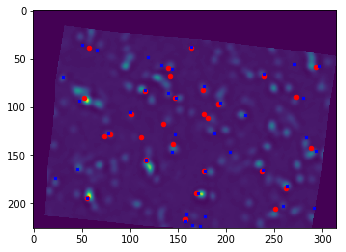

In [29]:
silce = 22
x = np.stack([collman[:,silce-1],collman[:,silce], collman[:,silce+1]],1)
y  = inference(net,x,False)

img = x[:,1].transpose((1,2,0))*2.
#img = np.dstack( ( img, np.ones_like(x[0])*0.5 ) )

plt.imshow(y[0,0]>0.7)
plt.imshow(img[:,:,0])
gt_pts = np.array([layer[silce][0],layer[silce][1]]).transpose(1,0)
coords = np.array([ list(p.centroid) for p in regionprops(label(y[0,0]>0.5)) if p.area>5])
plt.scatter(coords[:,1],coords[:,0],s=20, c='red', marker='o')
plt.scatter(gt_pts[:,0],gt_pts[:,1],s=7, c='blue', marker='x')

In [72]:
import pandas as pd
name = 'collman'
req_channels=['collman15v2_Synapsin647', 'collman15v2_VGluT1_647', 'collman15v2_PSD95_488']
dm=[]
for silce in range(2,25):
    x = collman[:,silce-2:silce+2].mean(axis=1)
    y  = inference(net,x)
    coords = np.array([ list(p.centroid) for p in regionprops(label(y[0,0]>0.5)) if p.area>1])
    
    for c in range(len(req_channels)):    
            desc = dognet.extract_descriptor(x[c],coords[:,0],coords[:,1],10,get_gaussian=dognet.get_gaussian)   
            dm+=[[silce,req_channels[c]]+d for d in desc]
            
dm = np.array(dm)            
d = {'fov': dm[:,0] , 'marker': dm[:,1],'x': dm[:,2] ,'y': dm[:,3] ,'A': dm[:,4] ,'L1': dm[:,5]
     ,'L2': dm[:,6] ,'sigmax2': dm[:,7],'sigmay2': dm[:,8],'sigmaxy': dm[:,9],'angle': dm[:,10],
     'x_dog': dm[:,11],'y_dog': dm[:,12]}
df = pd.DataFrame(data=d)
df.to_csv(name+".csv")

In [7]:
from skimage.transform import resize
import hdf5storage

results = []
for silce in range(27):
    x = np.stack([collman[:,max(silce-1,0)],collman[:,silce], collman[:,min(silce+1,26)]],1)
    #x = collman[:,max(silce-2,0):min(silce+2,26)].mean(axis=1)
    y  = inference(net,x,False)
    results.append(resize(y[0,0]>0.3,(4518,6306)))
    
data = {u'resultVol':np.dstack(results).astype(np.double)}
hdf5storage.write(data, '.', 
                  '/media/hpc-4_Raid/vkulikov/hindus/probabilistic-synapse-detection/runme/collman_runme/myresults/resultVol_1.mat', 
                  matlab_compatible=True)

/home/vkulikov/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/vkulikov/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
